<a href="https://colab.research.google.com/github/smbonilla/learningPyTorch/blob/main/01_pyTorchWorkFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Workflow 

Exploring an example PyTorch end-to-end workflow.

In [1]:
whatWeCover = {1: "data (prepare and load)",
               2: "build model",
               3: "fitting model to data (training)",
               4: "making predictions and evaluating a model (inference)",
               5: "save and loading a model",
               6: "putting it all together"}

whatWeCover

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'save and loading a model',
 6: 'putting it all together'}

In [2]:
import torch 
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt 

# Check PyTorch version
torch.__version__

'1.12.1+cu113'

## 1. Data (preparing and loading)

data can be almost anything in machine learning. 
* excel spreadsheet
* images of any kind
* videos
* audio 
* DNA
* text

machine learning is a game of two parts: 
1. get data into numerical representation
2. build a model to learn patterns in that numerical representation

In [3]:
# create *known* parameters

weight = 0.7 # m in linear regression eq
bias = 0.3 # b in linear regression eq 

start = 0 
end = 1
step = 0.02 

# input (need extra dimension for model later)
X = torch.arange(start, end, step).unsqueeze(dim = 1)

# output 
y = weight * X + bias 

### Splitting data into training and test sets

**very** important sets:
1. training set (70%) **always**
2. validation set - tune model patterns (15%) **often**
3. test set - see if the model is ready for the wild (15%) **always**

Generalization: the ability for a machine learning model to perform well on data it hasn't seen before.

In [4]:
# splitting training and test 

trainSplit = int(0.8*len(X))

XTrain, yTrain = X[:trainSplit], y[:trainSplit] # not random splitting 

XTest, yTest = X[trainSplit:], y[trainSplit:] # not random splitting

len(XTrain), len(yTrain), len(XTest), len(yTest)

(40, 40, 10, 10)

In [5]:
# visualize data 

def plotPredictions(trainData = XTrain,
                    trainLabels = yTrain,
                    testData=XTest,
                    testLabels = yTest, 
                    predictions = None):
  """
  Plots training data, test data and compares predictions
  """

  plt.figure(figsize=(10,7))

  # plot training data in blue
  plt.scatter(trainData, trainLabels, c="b", s=4, label="TRAINING DATA")

  # plot test data in green 
  plt.scatter(testData, testLabels, c="g", s=4, label="TESTING DATA")

  # are there predictions?
  if predictions is not None:
    
    # plot predictions if exist
    plt.scatter(testData, predictions, c="r", s=4, label="PREDICTED DATA")

  # show the legend
  plt.legend(prop={"size": 14})

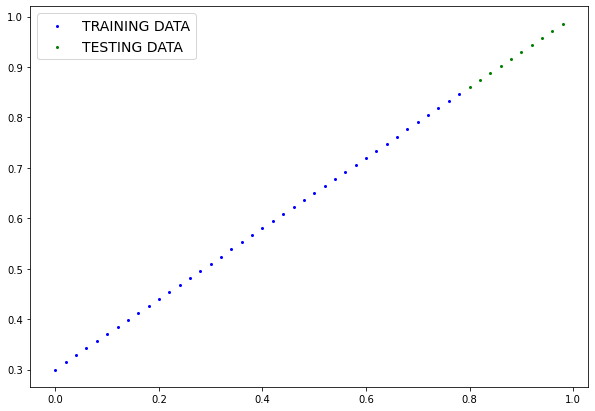

In [6]:
plotPredictions()

## 2. Build model

Our first PyTorch model!

What our model does:
* start with random values for weight & bias
* look at training data and adjust the random values to better represent the ideal values

How does it do this? 
- Two main algorithms:
  1. gradient descent 
  2. backpropagation

In [7]:
# create a linear regression model class 

class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from nn.module
  def __init__(self):
    super().__init__()

    # Initialize model parameters
    self.weights = nn.Parameter(torch.randn(1, # start with a random weight and try to adjust it to ideal weight
                                            requires_grad=True, # can this paramter be updated via gradient descent
                                            dtype=torch.float)) # PyTorch loves the datatype torch.float32
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))
    
  # forward method to define the computation in the model 
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights*x + self.bias # this is the linear regression formula


### PyTorch model building essentials

* `torch.nn` - contains all of the buildings for computational graphs (a neural network can be considered a computation graph)
* `torch.nn.Parameter` - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* `torch.nn.Module` - the base class for all neural network modules, if you subclass if, you should overwrite forward()
* `torch.optim` - where the optimizers in PyTorch live, they will help with gradient descent
* `def forward ()` - All `nn.Module` subclasses require you to overwite `forward()` 

### Checking the contents of our PyTorch model

check out our model parameters by using `.parameters()`

In [8]:
# create a random seed 
torch.manual_seed(42)

# create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# check our parameters two ways
list(model_0.parameters())

model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

to check our model's predictive power, let's see how well it predicts `yTest` based on `XTest`

when we pass data through our model, it's going to run it through `forward()` method

In [9]:
# make predictions with model and can do something similar with torch.no_grad()

with torch.inference_mode(): # when we are doing inference, we are not training so keeping track of less data - no need to track grad
  yPreds = model_0(XTest)

yPreds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

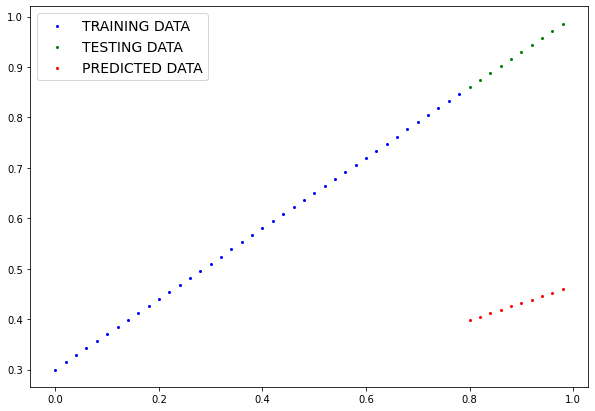

In [10]:
plotPredictions(predictions=yPreds)

## 3. Train model 

The idea of training is for this model to move from *random* parameters to our *known* parameters 
- from a poor representation of the data to a better representation of the data

One way to measure how poor the predictions are is to use a loss function.
* Note: loss function may also be called cost function or criterion in different areas. for our case, we're going to refer to it as a loss function

Things we use to train:
* **Loss function:** a function to measure how wrong your model's predictions are to the ideas outputs, lower is better

* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias) to lower the loss

PyTorch, we need:
* a training loop
* a testing loop

In [11]:
# Setup a loss function 
lossFn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(model_0.parameters(), 
                            lr = 0.001) # lr = learning rate -> possibly the most important hyperparameter -> change in parameters

### Building a training loop (and a testing loop) in PyTorch

what do we need:
0. loop through the data
1. forward pass (data moving through our model's `forward()`) to make predictions on data
2. calculate the loss (compare forward pass predictions to ground truth labels)
3. optimize zero grad 
4. loss backward - move backwards through the network to calculate gradients of each parameter (**backpropagation**)
5. optimizer step - use the optimizer to adjust our model's parameters to try and improve loss (**gradient descent**) 

In [12]:
torch.manual_seed(42)

# an Epoch is one loop through the data (this is a hyperparameter because we have set it ourselves)
epochs = 400

# Track different values
epochCount = [] 
lossValues = [] # tracking experiments
testLossValues = [] 

### Training 

# 0. Loop through data
for epoch in range(epochs):

  # set the model to training mode 
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

  # 1. Forward pass
  yPred = model_0(XTrain)

  # 2. Calculate the loss
  loss = lossFn(yPred,yTrain)

  # 3. Optimizer zero grad
  optimizer.zero_grad() # start fresh so it doesn't accumulate

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop, so we have to zero them above in step 3 for the next iteration

  ### Testing
  model_0.eval() # turns off different settings in the model not needed for eval/testing (dropout/batch norm layers)

  with torch.inference_mode(): # turns off gradient tracking 
    
    # 1. Forward pass 
    testPred = model_0(XTest)

    # 2. calculate the loss
    testLoss = lossFn(testPred,yTest)

  # print out what's happening
  if epoch%10 == 0:
    epochCount.append(epoch)
    lossValues.append(loss)
    testLossValues.append(testLoss)

    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {testLoss}")
    print(model_0.state_dict())


Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.4931890368461609
OrderedDict([('weights', tensor([0.3371])), ('bias', tensor([0.1298]))])
Epoch: 10 | Loss: 0.3013603389263153 | Test loss: 0.4797181189060211
OrderedDict([('weights', tensor([0.3410])), ('bias', tensor([0.1398]))])
Epoch: 20 | Loss: 0.28983938694000244 | Test loss: 0.4662471413612366
OrderedDict([('weights', tensor([0.3449])), ('bias', tensor([0.1498]))])
Epoch: 30 | Loss: 0.2783183455467224 | Test loss: 0.4527761936187744
OrderedDict([('weights', tensor([0.3488])), ('bias', tensor([0.1598]))])
Epoch: 40 | Loss: 0.26679736375808716 | Test loss: 0.43930521607398987
OrderedDict([('weights', tensor([0.3527])), ('bias', tensor([0.1698]))])
Epoch: 50 | Loss: 0.2552763819694519 | Test loss: 0.4258342385292053
OrderedDict([('weights', tensor([0.3566])), ('bias', tensor([0.1798]))])
Epoch: 60 | Loss: 0.24375538527965546 | Test loss: 0.41236335039138794
OrderedDict([('weights', tensor([0.3605])), ('bias', tensor([0.1898]))])
E

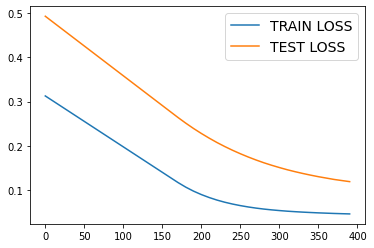

In [13]:
# Plot the loss curves 
import numpy as np
# np.array(torch.tensor(lossValues))

plt.plot(epochCount, np.array(torch.tensor(lossValues)), label="TRAIN LOSS")
plt.plot(epochCount, testLossValues, label ="TEST LOSS")
plt.legend(prop={"size":14})

In [14]:
with torch.inference_mode():
  yPredsNew = model_0(XTest)
  print(model_0.state_dict())

OrderedDict([('weights', tensor([0.4728])), ('bias', tensor([0.3854]))])


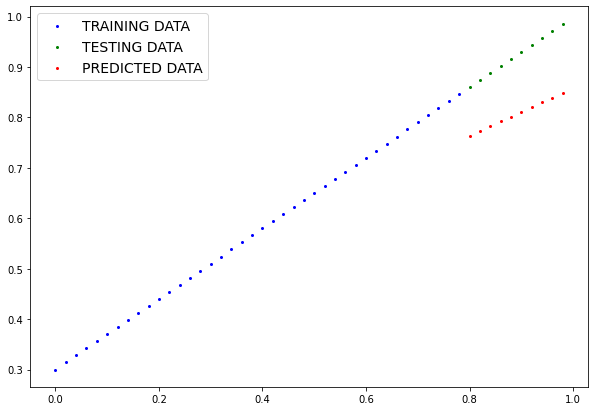

In [15]:
plotPredictions(predictions=yPredsNew)

## Saving a model in PyTorch 

There are three main methods for saving and loading models in PyTorch:
1. `torch.save()` - save a PyTorch object in Python's pickle format
2. `torch.load()` - load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - load a model's save state dictionary 

In [17]:
# Saving our PyTorch model 
from pathlib import Path 

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path either .pt or .pth
MODEL_NAME = "01_pyTorchWorkFlow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME 

MODEL_SAVE_PATH

PosixPath('models/01_pyTorchWorkFlow_model_0.pth')

In [18]:
# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), 
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pyTorchWorkFlow_model_0.pth


In [20]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1063 Dec  1 12:22 01_pyTorchWorkFlow_model_0.pth


In [22]:
# 4. Load PyTorch parameters - only saved `state_dict()` so need to instantiate a new instance of model class
loaded_model_0 = LinearRegressionModel()

# load saved state_dict or model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.4728])), ('bias', tensor([0.3854]))])

In [24]:
# Testing loaded model: make some predictions
loaded_model_0.eval() 

with torch.inference_mode():
  loadedModelPreds = loaded_model_0(XTest)

# old model
model_0.eval()

with torch.inference_mode():
  yPreds = model_0(XTest)

# checking
loadedModelPreds == yPreds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# 6. Putting it all together 

coding it all in one place

In [26]:
# Import PyTorch and matplotlib 
import torch
from torch import nn
import matplotlib.pyplot as plt

# check pytorch version 
torch.__version__

'1.12.1+cu113'

In [28]:
# setup device agnostic code 
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [31]:
# create dummy data set - y = weight * X + bias
weight = 0.7
bias = 0.3 

# create range values 
start = 0 
end = 1 
step = 0.02 

# create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will pop up
y = weight * X + bias 

# split data in training and test
trainSplit = int(0.8*len(X))
XTrain, yTrain = X[:trainSplit], y[:trainSplit]
XTest, yTest = X[trainSplit:], y[trainSplit:]

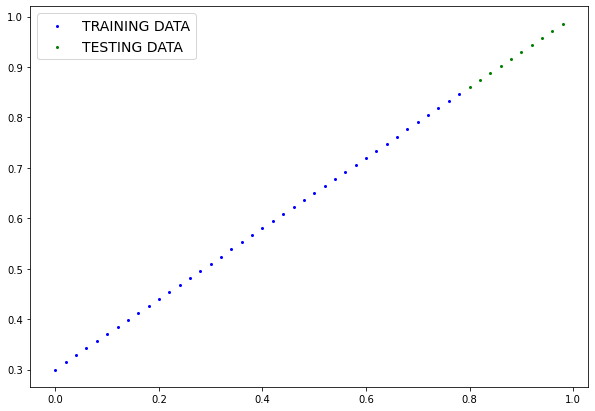

In [32]:
# Plot the data - note: using plotPredictions()
plotPredictions(XTrain, yTrain, XTest, yTest)

In [37]:
# build PyTorch linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    # Use nn.Linear() for creating model parameters / aka: linear transform, probing layer, fully connected layer, dense layer
    self.linearLayer = nn.Linear(in_features=1, # one value of x
                                 out_features=1) # one value of y

  def forward(self, x:torch.Tensor) -> torch.Tensor: # x should be a torch.Tensor and it should return torch.Tensor
    return self.linearLayer(x)

# Set the manual seed
torch.manual_seed(42)

model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict() # values will be different because diff form of randomnness


(LinearRegressionModelV2(
   (linearLayer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linearLayer.weight', tensor([[0.7645]])),
              ('linearLayer.bias', tensor([0.8300]))]))

In [38]:
# set model to use the target device 
model_1.to(device)
next(model_1.parameters()).device

device(type='cpu')

In [39]:
# training 

# loss function
lossFn = nn.L1Loss() # same as MAE

# optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.01)

# training loop
torch.manual_seed(42)

epochs = 200

# device agnostic code for data
XTrain = XTrain.to(device)
yTrain = yTrain.to(device)
XTest = XTest.to(device)
yTest = yTest.to(device)

for epoch in range(epochs):

  # train
  model_1.train()

  # 1. forward pass
  yPred = model_1(XTrain)

  # 2. Calculate the loss
  loss = lossFn(yPred, yTrain)

  # 3. optimizer 0 grad
  optimizer.zero_grad()

  # 4. perform backpropagation 
  loss.backward()

  # 5. optimizer step 
  optimizer.step()

  # testing loop

  # eval
  model_1.eval()

  with torch.inference_mode():
    testPred = model_1(XTest)

    testLoss = lossFn(testPred, yTest)

  # print stuff out 
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {testLoss}")

Epoch: 0 | Loss: 0.5551779866218567 | Test Loss: 0.5739762187004089
Epoch: 10 | Loss: 0.4399680495262146 | Test Loss: 0.4392663538455963
Epoch: 20 | Loss: 0.3247582018375397 | Test Loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954827964305878 | Test Loss: 0.16984674334526062
Epoch: 40 | Loss: 0.09433844685554504 | Test Loss: 0.03513689711689949
Epoch: 50 | Loss: 0.023886386305093765 | Test Loss: 0.04784906655550003
Epoch: 60 | Loss: 0.0199567973613739 | Test Loss: 0.04580312222242355
Epoch: 70 | Loss: 0.016517987474799156 | Test Loss: 0.0375305712223053
Epoch: 80 | Loss: 0.013089170679450035 | Test Loss: 0.029944902285933495
Epoch: 90 | Loss: 0.009653178043663502 | Test Loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215679459273815 | Test Loss: 0.014086711220443249
Epoch: 110 | Loss: 0.002787243574857712 | Test Loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test Loss: 0.013801807537674904
Epoch: 130 | Loss: 0.0012645035749301314 | Test Loss: 0.01380180753767

Model state_dict(): OrderedDict([('linearLayer.weight', tensor([[0.6968]])), ('linearLayer.bias', tensor([0.3025]))])


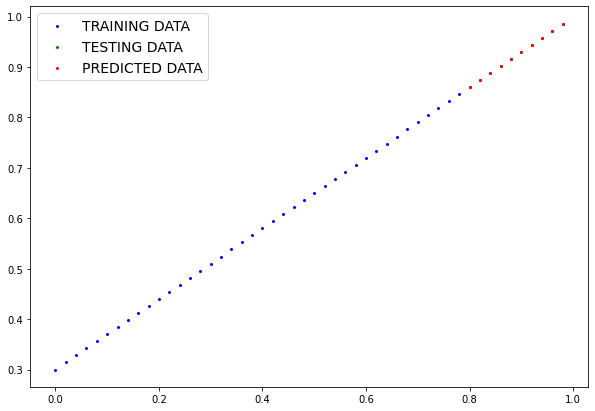

In [43]:
# visualize!! 

plotPredictions(predictions=testPred)

print(f"Model state_dict(): {model_1.state_dict()}")